## Import Libraries

In [ ]:
import os
import glob
import re
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim import AdamW

# Compatibility fix for transformers library
if not hasattr(torch.utils._pytree, 'register_pytree_node'):
    torch.utils._pytree.register_pytree_node = lambda *args, **kwargs: None

from transformers import (
    BertTokenizer, 
    BertForSequenceClassification, 
    get_linear_schedule_with_warmup
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)

Using device: cuda


## Configuration

In [ ]:
# Data configuration
DATA_PATH = "Raw Data/all"
FEATURE_COLUMNS = ['FPOGX', 'FPOGY']

# BERT configuration
MODEL_NAME = 'bert-base-uncased'
MAX_LENGTH = 256
BATCH_SIZE = 4
LEARNING_RATE = 2e-5
NUM_EPOCHS = 3
WARMUP_STEPS = 50
MAX_GRAD_NORM = 1.0


## Data Loading and Preprocessing with User ID Extraction

In [ ]:
class EyeTrackingDataset(Dataset):
    def __init__(self, data_path, feature_columns, tokenizer, max_length=256, normalize=True):
        self.data_path = data_path
        self.feature_columns = feature_columns
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.normalize = normalize
        
        self.samples = []
        self.labels = []
        self.user_ids = []
        self.sequences = []
        
        self._load_data()
        self._preprocess_sequences()
        
    def _load_data(self):
        """Load CSV files and extract sequences with user IDs"""
        print("Loading data files...")
        
        label_map = {'literate': 1, 'illiterate': 0}
        
        for label_name, label_value in label_map.items():
            folder_path = os.path.join(self.data_path, label_name)
            if not os.path.exists(folder_path):
                print(f"Warning: {folder_path} does not exist")
                continue
                
            csv_files = glob.glob(os.path.join(folder_path, "*.csv"))
            print(f"Found {len(csv_files)} files in {label_name} folder")
            
            for csv_file in tqdm(csv_files, desc=f"Loading {label_name} files"):
                try:
                    df = pd.read_csv(csv_file)
                    
                    filename = os.path.basename(csv_file)
                    user_id = int(filename.split('_')[1])
                    
                    feature_data = df[self.feature_columns].copy()
                    feature_data = feature_data.fillna(feature_data.mean())
                    
                    if len(feature_data) > 0:
                        self.samples.append(csv_file)
                        self.labels.append(label_value)
                        self.user_ids.append(user_id)
                        self.sequences.append(feature_data.values)
                        
                except Exception as e:
                    print(f"Error loading {csv_file}: {e}")
                    continue
        
        print(f"Loaded {len(self.samples)} samples total")
        print(f"Unique users: {len(set(self.user_ids))}")
        print(f"Label distribution: {pd.Series(self.labels).value_counts().to_dict()}")
    
    def _preprocess_sequences(self):
        """Preprocess sequences for BERT input"""
        print("Preprocessing sequences...")
        
        if self.normalize:
            all_values = np.concatenate([seq.flatten() for seq in self.sequences])
            all_values = all_values[np.isfinite(all_values)]
            
            self.global_mean = np.mean(all_values)
            self.global_std = np.std(all_values)
            
            print(f"Global mean: {self.global_mean:.4f}, Global std: {self.global_std:.4f}")
        
        self.text_sequences = []
        
        for seq in tqdm(self.sequences, desc="Converting to text"):
            if self.normalize and self.global_std > 0:
                seq_normalized = (seq - self.global_mean) / self.global_std
                seq_normalized = np.clip(seq_normalized, -5, 5)
            else:
                seq_normalized = seq
            
            text_tokens = []
            for time_step in seq_normalized:
                feature_str = " ".join([f"{val:.2f}" for val in time_step])
                text_tokens.append(f"[{feature_str}]")
            
            text_sequence = " ".join(text_tokens)
            self.text_sequences.append(text_sequence)
        
        if self.text_sequences:
            print(f"Sample text sequence (first 200 chars): {self.text_sequences[0][:200]}...")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        text = self.text_sequences[idx]
        label = self.labels[idx]
        user_id = self.user_ids[idx]
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long),
            'user_id': user_id
        }


## Initialize Dataset and Tokenizer

In [4]:
# Initialize tokenizer
print("Loading BERT tokenizer...")
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

# Load dataset
print("\nLoading dataset...")
dataset = EyeTrackingDataset(
    data_path=DATA_PATH,
    feature_columns=FEATURE_COLUMNS,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH,
    normalize=True
)

print(f"\nDataset loaded successfully!")
print(f"Total samples: {len(dataset)}")
print(f"Number of unique users: {len(dataset.get_unique_users())}")

Loading BERT tokenizer...

Loading dataset...
Loading data files...
Found 650 files in literate folder


Loading literate files: 100%|██████████| 650/650 [00:07<00:00, 86.04it/s] 


Found 849 files in illiterate folder


Loading illiterate files: 100%|██████████| 849/849 [00:10<00:00, 83.68it/s] 


Loaded 1499 samples total
Label distribution: {1: 849, 0: 650}
Number of unique users: 30
User IDs: [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
Preprocessing sequences...
Preprocessing complete

Dataset loaded successfully!
Total samples: 1499
Number of unique users: 30


## Training and Evaluation Functions

In [5]:
def train_epoch(model, dataloader, optimizer, scheduler, device, gradient_accumulation_steps=1):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    predictions = []
    true_labels = []
    
    optimizer.zero_grad()
    
    progress_bar = tqdm(dataloader, desc="Training")
    for step, batch in enumerate(progress_bar):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss / gradient_accumulation_steps
        loss.backward()
        
        if (step + 1) % gradient_accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
        
        total_loss += loss.item() * gradient_accumulation_steps
        
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
        
        progress_bar.set_postfix({'loss': loss.item() * gradient_accumulation_steps})
    
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(true_labels, predictions)
    
    return avg_loss, accuracy

def evaluate(model, dataloader, device):
    """Evaluate model"""
    model.eval()
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, predictions, average='macro', zero_division=0
    )
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions': predictions,
        'true_labels': true_labels
    }

## Leave-One-User-Out Cross-Validation

In [ ]:
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

dataset = EyeTrackingDataset(
    data_path=DATA_PATH,
    feature_columns=FEATURE_COLUMNS,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH,
    normalize=True
)

print(f"\nDataset created with {len(dataset)} samples")

fold_results = []
all_predictions = []
all_true_labels = []

unique_users = sorted(set(dataset.user_ids))
print(f"Training with LOUO on {len(unique_users)} users")

for test_user in unique_users:
    print(f"\n{'='*50}")
    print(f"TESTING USER {test_user}")
    print(f"{'='*50}")
    
    train_indices = [i for i, uid in enumerate(dataset.user_ids) if uid != test_user]
    test_indices = [i for i, uid in enumerate(dataset.user_ids) if uid == test_user]
    
    train_subset = torch.utils.data.Subset(dataset, train_indices)
    test_subset = torch.utils.data.Subset(dataset, test_indices)
    
    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False)
    
    print(f"Train samples: {len(train_subset)}, Test samples: {len(test_subset)}")
    
    model = BertForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=2,
        output_attentions=False,
        output_hidden_states=False
    )
    model.to(device)
    
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=1e-8)
    total_steps = len(train_loader) * NUM_EPOCHS
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=WARMUP_STEPS,
        num_training_steps=total_steps
    )
    
    for epoch in range(NUM_EPOCHS):
        model.train()
        total_loss = 0
        
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}"):
            optimizer.zero_grad()
            
            outputs = model(
                input_ids=batch['input_ids'].to(device),
                attention_mask=batch['attention_mask'].to(device),
                labels=batch['labels'].to(device)
            )
            
            loss = outputs.loss
            total_loss += loss.item()
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
            optimizer.step()
            scheduler.step()
        
        torch.cuda.empty_cache()
    
    model.eval()
    test_predictions = []
    test_labels = []
    
    with torch.no_grad():
        for batch in test_loader:
            outputs = model(
                input_ids=batch['input_ids'].to(device),
                attention_mask=batch['attention_mask'].to(device)
            )
            
            predictions = torch.argmax(outputs.logits, dim=-1)
            test_predictions.extend(predictions.cpu().numpy())
            test_labels.extend(batch['labels'].numpy())
    
    accuracy = accuracy_score(test_labels, test_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        test_labels, test_predictions, average='binary', zero_division=0
    )
    
    fold_results.append({
        'user': test_user,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    })
    
    all_predictions.extend(test_predictions)
    all_true_labels.extend(test_labels)
    
    print(f"User {test_user} Results - Acc: {accuracy:.4f}, P: {precision:.4f}, R: {recall:.4f}, F1: {f1:.4f}")
    
    del model
    torch.cuda.empty_cache()


Starting Leave-One-User-Out Cross-Validation
Number of folds: 30
Unique users: [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]

Fold 1/30 - Testing on User 1
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training for 3 epochs...

Epoch 1/3


Training: 100%|██████████| 363/363 [00:11<00:00, 32.73it/s, loss=0.487]


Train Loss: 0.6891 | Train Acc: 0.5507

Epoch 2/3


Training: 100%|██████████| 363/363 [00:10<00:00, 33.92it/s, loss=0.644]


Train Loss: 0.6569 | Train Acc: 0.6128

Epoch 3/3


Training: 100%|██████████| 363/363 [00:10<00:00, 33.73it/s, loss=1.09] 


Train Loss: 0.5907 | Train Acc: 0.6812

Evaluating on User 1...


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 71.47it/s]



User 1 Results:
  Accuracy:  0.1800
  Precision: 0.5000
  Recall:    0.0900
  F1-Score:  0.1525

Fold 2/30 - Testing on User 2
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training for 3 epochs...

Epoch 1/3


Training: 100%|██████████| 363/363 [00:10<00:00, 33.69it/s, loss=0.898]


Train Loss: 0.6940 | Train Acc: 0.5342

Epoch 2/3


Training: 100%|██████████| 363/363 [00:10<00:00, 33.76it/s, loss=0.551]


Train Loss: 0.6996 | Train Acc: 0.5335

Epoch 3/3


Training: 100%|██████████| 363/363 [00:10<00:00, 33.62it/s, loss=0.44] 


Train Loss: 0.6909 | Train Acc: 0.5431

Evaluating on User 2...


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 85.08it/s]



User 2 Results:
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000

Fold 3/30 - Testing on User 3
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training for 3 epochs...

Epoch 1/3


Training: 100%|██████████| 363/363 [00:10<00:00, 33.50it/s, loss=0.495]


Train Loss: 0.6919 | Train Acc: 0.5328

Epoch 2/3


Training: 100%|██████████| 363/363 [00:10<00:00, 33.75it/s, loss=0.704]


Train Loss: 0.6571 | Train Acc: 0.6266

Epoch 3/3


Training: 100%|██████████| 363/363 [00:10<00:00, 33.66it/s, loss=0.911]


Train Loss: 0.6156 | Train Acc: 0.6791

Evaluating on User 3...


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 49.74it/s]



User 3 Results:
  Accuracy:  0.5400
  Precision: 0.5000
  Recall:    0.2700
  F1-Score:  0.3506

Fold 4/30 - Testing on User 4
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training for 3 epochs...

Epoch 1/3


Training: 100%|██████████| 363/363 [00:10<00:00, 33.41it/s, loss=0.981]


Train Loss: 0.6923 | Train Acc: 0.5556

Epoch 2/3


Training: 100%|██████████| 363/363 [00:10<00:00, 33.48it/s, loss=1.1]  


Train Loss: 0.6746 | Train Acc: 0.6115

Epoch 3/3


Training: 100%|██████████| 363/363 [00:10<00:00, 33.52it/s, loss=0.609]


Train Loss: 0.6410 | Train Acc: 0.6253

Evaluating on User 4...


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 70.35it/s]



User 4 Results:
  Accuracy:  0.0400
  Precision: 0.5000
  Recall:    0.0200
  F1-Score:  0.0385


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Fold 5/30 - Testing on User 6
Training samples: 1449
Test samples: 50

Training for 3 epochs...

Epoch 1/3


Training: 100%|██████████| 363/363 [00:10<00:00, 33.44it/s, loss=1.15] 


Train Loss: 0.7022 | Train Acc: 0.5459

Epoch 2/3


Training: 100%|██████████| 363/363 [00:10<00:00, 33.43it/s, loss=0.572]


Train Loss: 0.6843 | Train Acc: 0.5880

Epoch 3/3


Training: 100%|██████████| 363/363 [00:10<00:00, 33.39it/s, loss=0.283]


Train Loss: 0.6608 | Train Acc: 0.6239

Evaluating on User 6...


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 87.36it/s]



User 6 Results:
  Accuracy:  0.8400
  Precision: 0.5000
  Recall:    0.4200
  F1-Score:  0.4565

Fold 6/30 - Testing on User 7
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training for 3 epochs...

Epoch 1/3


Training: 100%|██████████| 363/363 [00:10<00:00, 33.52it/s, loss=0.6]  


Train Loss: 0.7039 | Train Acc: 0.5528

Epoch 2/3


Training: 100%|██████████| 363/363 [00:10<00:00, 33.54it/s, loss=0.465]


Train Loss: 0.6623 | Train Acc: 0.6142

Epoch 3/3


Training: 100%|██████████| 363/363 [00:10<00:00, 33.48it/s, loss=0.439]


Train Loss: 0.6100 | Train Acc: 0.6818

Evaluating on User 7...


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 69.76it/s]



User 7 Results:
  Accuracy:  0.0400
  Precision: 0.5000
  Recall:    0.0200
  F1-Score:  0.0385

Fold 7/30 - Testing on User 8
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training for 3 epochs...

Epoch 1/3


Training: 100%|██████████| 363/363 [00:10<00:00, 33.45it/s, loss=0.581]


Train Loss: 0.6843 | Train Acc: 0.5707

Epoch 2/3


Training: 100%|██████████| 363/363 [00:10<00:00, 33.53it/s, loss=0.926]


Train Loss: 0.6910 | Train Acc: 0.5473

Epoch 3/3


Training: 100%|██████████| 363/363 [00:10<00:00, 33.47it/s, loss=0.573]


Train Loss: 0.6805 | Train Acc: 0.5769

Evaluating on User 8...


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 82.93it/s]



User 8 Results:
  Accuracy:  0.3600
  Precision: 0.5000
  Recall:    0.1800
  F1-Score:  0.2647

Fold 8/30 - Testing on User 9
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training for 3 epochs...

Epoch 1/3


Training: 100%|██████████| 363/363 [00:10<00:00, 33.48it/s, loss=0.286]


Train Loss: 0.6881 | Train Acc: 0.5473

Epoch 2/3


Training: 100%|██████████| 363/363 [00:10<00:00, 33.49it/s, loss=0.329]


Train Loss: 0.6545 | Train Acc: 0.6156

Epoch 3/3


Training: 100%|██████████| 363/363 [00:10<00:00, 33.52it/s, loss=0.576] 


Train Loss: 0.6046 | Train Acc: 0.6770

Evaluating on User 9...


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 71.01it/s]



User 9 Results:
  Accuracy:  0.0000
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000

Fold 9/30 - Testing on User 10
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training for 3 epochs...

Epoch 1/3


Training: 100%|██████████| 363/363 [00:10<00:00, 33.42it/s, loss=0.348]


Train Loss: 0.6723 | Train Acc: 0.6004

Epoch 2/3


Training: 100%|██████████| 363/363 [00:10<00:00, 33.53it/s, loss=0.78] 


Train Loss: 0.6449 | Train Acc: 0.6473

Epoch 3/3


Training: 100%|██████████| 363/363 [00:10<00:00, 33.51it/s, loss=0.455]


Train Loss: 0.6194 | Train Acc: 0.6756

Evaluating on User 10...


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 81.52it/s]



User 10 Results:
  Accuracy:  0.3600
  Precision: 0.5000
  Recall:    0.1800
  F1-Score:  0.2647

Fold 10/30 - Testing on User 11
Training samples: 1450
Test samples: 49


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training for 3 epochs...

Epoch 1/3


Training: 100%|██████████| 363/363 [00:10<00:00, 33.34it/s, loss=0.541]


Train Loss: 0.7012 | Train Acc: 0.5317

Epoch 2/3


Training: 100%|██████████| 363/363 [00:11<00:00, 32.93it/s, loss=0.112]


Train Loss: 0.6446 | Train Acc: 0.6269

Epoch 3/3


Training: 100%|██████████| 363/363 [00:11<00:00, 32.68it/s, loss=0.458]


Train Loss: 0.6151 | Train Acc: 0.6559

Evaluating on User 11...


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 87.32it/s]



User 11 Results:
  Accuracy:  0.9592
  Precision: 0.5000
  Recall:    0.4796
  F1-Score:  0.4896

Fold 11/30 - Testing on User 12
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training for 3 epochs...

Epoch 1/3


Training: 100%|██████████| 363/363 [00:11<00:00, 32.88it/s, loss=0.556]


Train Loss: 0.6824 | Train Acc: 0.5714

Epoch 2/3


Training: 100%|██████████| 363/363 [00:11<00:00, 32.91it/s, loss=0.599]


Train Loss: 0.6499 | Train Acc: 0.6287

Epoch 3/3


Training: 100%|██████████| 363/363 [00:11<00:00, 32.83it/s, loss=0.194]


Train Loss: 0.5932 | Train Acc: 0.6894

Evaluating on User 12...


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 59.41it/s]



User 12 Results:
  Accuracy:  0.1200
  Precision: 0.5000
  Recall:    0.0600
  F1-Score:  0.1071

Fold 12/30 - Testing on User 13
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training for 3 epochs...

Epoch 1/3


Training: 100%|██████████| 363/363 [00:11<00:00, 32.99it/s, loss=0.816]


Train Loss: 0.6936 | Train Acc: 0.5597

Epoch 2/3


Training: 100%|██████████| 363/363 [00:10<00:00, 33.42it/s, loss=0.716]


Train Loss: 0.6686 | Train Acc: 0.6025

Epoch 3/3


Training: 100%|██████████| 363/363 [00:10<00:00, 33.46it/s, loss=1.34]  


Train Loss: 0.6342 | Train Acc: 0.6273

Evaluating on User 13...


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 74.59it/s]



User 13 Results:
  Accuracy:  0.9800
  Precision: 0.5000
  Recall:    0.4900
  F1-Score:  0.4949

Fold 13/30 - Testing on User 14
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training for 3 epochs...

Epoch 1/3


Training: 100%|██████████| 363/363 [00:10<00:00, 33.50it/s, loss=1.39] 


Train Loss: 0.6719 | Train Acc: 0.5983

Epoch 2/3


Training: 100%|██████████| 363/363 [00:10<00:00, 33.48it/s, loss=0.261]


Train Loss: 0.6533 | Train Acc: 0.6280

Epoch 3/3


Training: 100%|██████████| 363/363 [00:10<00:00, 33.50it/s, loss=0.372]


Train Loss: 0.6258 | Train Acc: 0.6791

Evaluating on User 14...


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 67.71it/s]



User 14 Results:
  Accuracy:  0.2800
  Precision: 0.5000
  Recall:    0.1400
  F1-Score:  0.2188

Fold 14/30 - Testing on User 15
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training for 3 epochs...

Epoch 1/3


Training: 100%|██████████| 363/363 [00:10<00:00, 33.41it/s, loss=0.58] 


Train Loss: 0.6940 | Train Acc: 0.5362

Epoch 2/3


Training: 100%|██████████| 363/363 [00:10<00:00, 33.43it/s, loss=1.09] 


Train Loss: 0.6671 | Train Acc: 0.5935

Epoch 3/3


Training: 100%|██████████| 363/363 [00:10<00:00, 33.41it/s, loss=0.375]


Train Loss: 0.6512 | Train Acc: 0.6377

Evaluating on User 15...


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 88.97it/s]



User 15 Results:
  Accuracy:  0.2800
  Precision: 0.5000
  Recall:    0.1400
  F1-Score:  0.2188

Fold 15/30 - Testing on User 16
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training for 3 epochs...

Epoch 1/3


Training: 100%|██████████| 363/363 [00:10<00:00, 33.47it/s, loss=0.82] 


Train Loss: 0.6844 | Train Acc: 0.5783

Epoch 2/3


Training: 100%|██████████| 363/363 [00:10<00:00, 33.48it/s, loss=0.305]


Train Loss: 0.6717 | Train Acc: 0.5894

Epoch 3/3


Training: 100%|██████████| 363/363 [00:10<00:00, 33.51it/s, loss=0.826]


Train Loss: 0.6615 | Train Acc: 0.6115

Evaluating on User 16...


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 70.48it/s]



User 16 Results:
  Accuracy:  0.8200
  Precision: 0.5000
  Recall:    0.4100
  F1-Score:  0.4505

Fold 16/30 - Testing on User 17
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training for 3 epochs...

Epoch 1/3


Training: 100%|██████████| 363/363 [00:10<00:00, 33.31it/s, loss=0.673]


Train Loss: 0.6959 | Train Acc: 0.5404

Epoch 2/3


Training: 100%|██████████| 363/363 [00:10<00:00, 33.35it/s, loss=0.54] 


Train Loss: 0.6952 | Train Acc: 0.5328

Epoch 3/3


Training: 100%|██████████| 363/363 [00:10<00:00, 33.39it/s, loss=0.778]


Train Loss: 0.6719 | Train Acc: 0.5790

Evaluating on User 17...


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 97.98it/s]



User 17 Results:
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000

Fold 17/30 - Testing on User 18
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training for 3 epochs...

Epoch 1/3


Training: 100%|██████████| 363/363 [00:10<00:00, 33.47it/s, loss=0.961]


Train Loss: 0.6966 | Train Acc: 0.5300

Epoch 2/3


Training: 100%|██████████| 363/363 [00:10<00:00, 33.59it/s, loss=0.427]


Train Loss: 0.6737 | Train Acc: 0.5728

Epoch 3/3


Training: 100%|██████████| 363/363 [00:10<00:00, 33.57it/s, loss=2.46] 


Train Loss: 0.6360 | Train Acc: 0.6467

Evaluating on User 18...


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 62.65it/s]



User 18 Results:
  Accuracy:  0.7800
  Precision: 0.5000
  Recall:    0.3900
  F1-Score:  0.4382

Fold 18/30 - Testing on User 19
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training for 3 epochs...

Epoch 1/3


Training: 100%|██████████| 363/363 [00:10<00:00, 33.48it/s, loss=0.842]


Train Loss: 0.6950 | Train Acc: 0.5349

Epoch 2/3


Training: 100%|██████████| 363/363 [00:10<00:00, 33.48it/s, loss=0.896]


Train Loss: 0.6787 | Train Acc: 0.5970

Epoch 3/3


Training: 100%|██████████| 363/363 [00:10<00:00, 33.48it/s, loss=0.486]


Train Loss: 0.6291 | Train Acc: 0.6605

Evaluating on User 19...


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 71.78it/s]



User 19 Results:
  Accuracy:  0.3000
  Precision: 0.5000
  Recall:    0.1500
  F1-Score:  0.2308

Fold 19/30 - Testing on User 21
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training for 3 epochs...

Epoch 1/3


Training: 100%|██████████| 363/363 [00:10<00:00, 33.55it/s, loss=1.03] 


Train Loss: 0.6890 | Train Acc: 0.5535

Epoch 2/3


Training: 100%|██████████| 363/363 [00:10<00:00, 33.04it/s, loss=0.371]


Train Loss: 0.6817 | Train Acc: 0.5921

Epoch 3/3


Training: 100%|██████████| 363/363 [00:11<00:00, 32.66it/s, loss=0.26] 


Train Loss: 0.6549 | Train Acc: 0.6218

Evaluating on User 21...


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 61.88it/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



User 21 Results:
  Accuracy:  0.3400
  Precision: 0.5000
  Recall:    0.1700
  F1-Score:  0.2537

Fold 20/30 - Testing on User 22
Training samples: 1449
Test samples: 50

Training for 3 epochs...

Epoch 1/3


Training: 100%|██████████| 363/363 [00:11<00:00, 32.77it/s, loss=0.322]


Train Loss: 0.7058 | Train Acc: 0.5424

Epoch 2/3


Training: 100%|██████████| 363/363 [00:11<00:00, 32.98it/s, loss=0.295]


Train Loss: 0.6593 | Train Acc: 0.6073

Epoch 3/3


Training: 100%|██████████| 363/363 [00:11<00:00, 32.38it/s, loss=0.327]


Train Loss: 0.5937 | Train Acc: 0.6805

Evaluating on User 22...


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 61.56it/s]



User 22 Results:
  Accuracy:  0.2600
  Precision: 0.5000
  Recall:    0.1300
  F1-Score:  0.2063

Fold 21/30 - Testing on User 23
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training for 3 epochs...

Epoch 1/3


Training: 100%|██████████| 363/363 [00:11<00:00, 32.27it/s, loss=1.01] 


Train Loss: 0.6938 | Train Acc: 0.5638

Epoch 2/3


Training: 100%|██████████| 363/363 [00:11<00:00, 32.56it/s, loss=1.05] 


Train Loss: 0.6578 | Train Acc: 0.6197

Epoch 3/3


Training: 100%|██████████| 363/363 [00:11<00:00, 32.71it/s, loss=0.424]


Train Loss: 0.6491 | Train Acc: 0.6370

Evaluating on User 23...


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 81.46it/s]



User 23 Results:
  Accuracy:  0.2000
  Precision: 0.5000
  Recall:    0.1000
  F1-Score:  0.1667

Fold 22/30 - Testing on User 24
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training for 3 epochs...

Epoch 1/3


Training: 100%|██████████| 363/363 [00:11<00:00, 32.98it/s, loss=0.55] 


Train Loss: 0.6758 | Train Acc: 0.5783

Epoch 2/3


Training: 100%|██████████| 363/363 [00:11<00:00, 32.72it/s, loss=1.64] 


Train Loss: 0.6296 | Train Acc: 0.6646

Epoch 3/3


Training: 100%|██████████| 363/363 [00:11<00:00, 32.73it/s, loss=0.348]


Train Loss: 0.5876 | Train Acc: 0.7039

Evaluating on User 24...


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 58.20it/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



User 24 Results:
  Accuracy:  0.0800
  Precision: 0.5000
  Recall:    0.0400
  F1-Score:  0.0741

Fold 23/30 - Testing on User 25
Training samples: 1449
Test samples: 50

Training for 3 epochs...

Epoch 1/3


Training: 100%|██████████| 363/363 [00:11<00:00, 32.63it/s, loss=0.402]


Train Loss: 0.6930 | Train Acc: 0.5404

Epoch 2/3


Training: 100%|██████████| 363/363 [00:11<00:00, 31.49it/s, loss=0.511]


Train Loss: 0.6847 | Train Acc: 0.5804

Epoch 3/3


Training: 100%|██████████| 363/363 [00:11<00:00, 31.32it/s, loss=0.477]


Train Loss: 0.6615 | Train Acc: 0.5914

Evaluating on User 25...


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 72.89it/s]



User 25 Results:
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000

Fold 24/30 - Testing on User 26
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training for 3 epochs...

Epoch 1/3


Training: 100%|██████████| 363/363 [00:11<00:00, 31.12it/s, loss=0.746]


Train Loss: 0.6848 | Train Acc: 0.5728

Epoch 2/3


Training: 100%|██████████| 363/363 [00:11<00:00, 31.17it/s, loss=0.344]


Train Loss: 0.6589 | Train Acc: 0.6115

Epoch 3/3


Training: 100%|██████████| 363/363 [00:11<00:00, 31.42it/s, loss=0.282]


Train Loss: 0.6247 | Train Acc: 0.6605

Evaluating on User 26...


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 66.48it/s]



User 26 Results:
  Accuracy:  0.9400
  Precision: 0.5000
  Recall:    0.4700
  F1-Score:  0.4845

Fold 25/30 - Testing on User 27
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training for 3 epochs...

Epoch 1/3


Training: 100%|██████████| 363/363 [00:11<00:00, 31.17it/s, loss=0.648]


Train Loss: 0.6935 | Train Acc: 0.5452

Epoch 2/3


Training: 100%|██████████| 363/363 [00:11<00:00, 31.26it/s, loss=0.328]


Train Loss: 0.6746 | Train Acc: 0.5666

Epoch 3/3


Training: 100%|██████████| 363/363 [00:11<00:00, 32.29it/s, loss=0.501]


Train Loss: 0.6234 | Train Acc: 0.6404

Evaluating on User 27...


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 81.21it/s]



User 27 Results:
  Accuracy:  0.8400
  Precision: 0.5000
  Recall:    0.4200
  F1-Score:  0.4565

Fold 26/30 - Testing on User 28
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training for 3 epochs...

Epoch 1/3


Training: 100%|██████████| 363/363 [00:11<00:00, 32.48it/s, loss=0.753]


Train Loss: 0.6845 | Train Acc: 0.5721

Epoch 2/3


Training: 100%|██████████| 363/363 [00:11<00:00, 32.92it/s, loss=1.23] 


Train Loss: 0.6411 | Train Acc: 0.6473

Epoch 3/3


Training: 100%|██████████| 363/363 [00:11<00:00, 32.64it/s, loss=0.452]


Train Loss: 0.6299 | Train Acc: 0.6480

Evaluating on User 28...


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 87.02it/s]



User 28 Results:
  Accuracy:  0.0400
  Precision: 0.5000
  Recall:    0.0200
  F1-Score:  0.0385

Fold 27/30 - Testing on User 29
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training for 3 epochs...

Epoch 1/3


Training: 100%|██████████| 363/363 [00:11<00:00, 32.79it/s, loss=1.16] 


Train Loss: 0.6834 | Train Acc: 0.5901

Epoch 2/3


Training: 100%|██████████| 363/363 [00:11<00:00, 32.85it/s, loss=0.424]


Train Loss: 0.6494 | Train Acc: 0.6308

Epoch 3/3


Training: 100%|██████████| 363/363 [00:11<00:00, 32.50it/s, loss=0.0816]


Train Loss: 0.6053 | Train Acc: 0.6701

Evaluating on User 29...


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 70.95it/s]



User 29 Results:
  Accuracy:  0.5600
  Precision: 0.5000
  Recall:    0.2800
  F1-Score:  0.3590

Fold 28/30 - Testing on User 30
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training for 3 epochs...

Epoch 1/3


Training: 100%|██████████| 363/363 [00:11<00:00, 32.34it/s, loss=0.452]


Train Loss: 0.6871 | Train Acc: 0.5714

Epoch 2/3


Training: 100%|██████████| 363/363 [00:11<00:00, 32.55it/s, loss=0.385]


Train Loss: 0.6552 | Train Acc: 0.6280

Epoch 3/3


Training: 100%|██████████| 363/363 [00:11<00:00, 32.42it/s, loss=0.188]


Train Loss: 0.6229 | Train Acc: 0.6556

Evaluating on User 30...


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 62.28it/s]



User 30 Results:
  Accuracy:  0.2800
  Precision: 0.5000
  Recall:    0.1400
  F1-Score:  0.2188

Fold 29/30 - Testing on User 31
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training for 3 epochs...

Epoch 1/3


Training: 100%|██████████| 363/363 [00:11<00:00, 32.43it/s, loss=0.974]


Train Loss: 0.6860 | Train Acc: 0.5742

Epoch 2/3


Training: 100%|██████████| 363/363 [00:11<00:00, 32.37it/s, loss=0.72] 


Train Loss: 0.6677 | Train Acc: 0.5845

Epoch 3/3


Training: 100%|██████████| 363/363 [00:11<00:00, 31.70it/s, loss=0.213]


Train Loss: 0.6443 | Train Acc: 0.6432

Evaluating on User 31...


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 90.00it/s]



User 31 Results:
  Accuracy:  0.8800
  Precision: 0.5000
  Recall:    0.4400
  F1-Score:  0.4681

Fold 30/30 - Testing on User 32
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training for 3 epochs...

Epoch 1/3


Training: 100%|██████████| 363/363 [00:10<00:00, 33.29it/s, loss=0.552]


Train Loss: 0.6962 | Train Acc: 0.5349

Epoch 2/3


Training: 100%|██████████| 363/363 [00:10<00:00, 33.33it/s, loss=0.44] 


Train Loss: 0.6662 | Train Acc: 0.5866

Epoch 3/3


Training: 100%|██████████| 363/363 [00:10<00:00, 33.36it/s, loss=0.273]


Train Loss: 0.6236 | Train Acc: 0.6591

Evaluating on User 32...


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 90.08it/s]


User 32 Results:
  Accuracy:  0.7600
  Precision: 0.5000
  Recall:    0.3800
  F1-Score:  0.4318

Leave-One-User-Out Cross-Validation Complete!


## Aggregate Results and Analysis

In [ ]:
# Convert results to DataFrame
results_df = pd.DataFrame(louo_results)
predictions_df = pd.DataFrame(all_predictions)

mean_accuracy = results_df['accuracy'].mean()
std_accuracy = results_df['accuracy'].std()
mean_precision = results_df['precision'].mean()
std_precision = results_df['precision'].std()
mean_recall = results_df['recall'].mean()
std_recall = results_df['recall'].std()
mean_f1 = results_df['f1'].mean()
std_f1 = results_df['f1'].std()

print("\nAggregate Results (Mean ± Std):")
print(f"Accuracy:  {mean_accuracy:.4f} ± {std_accuracy:.4f}")
print(f"Precision: {mean_precision:.4f} ± {std_precision:.4f}")
print(f"Recall:    {mean_recall:.4f} ± {std_recall:.4f}")
print(f"F1-Score:  {mean_f1:.4f} ± {std_f1:.4f}")

# Display per-user results
print("\nPer-User Results:")
print(results_df.sort_values('accuracy', ascending=False).to_string(index=False))

# Save results
results_df.to_csv('bert_2col_louo_results.csv', index=False)
predictions_df.to_csv('bert_2col_louo_predictions.csv', index=False)
print("\nResults saved to:")
print("  - bert_2col_louo_results.csv")
print("  - bert_2col_louo_predictions.csv")


Aggregate Results (Mean ± Std):
Accuracy:  0.5020 ± 0.3581
Precision: 0.5333 ± 0.1826
Recall:    0.3010 ± 0.2848
F1-Score:  0.3458 ± 0.2703

Per-User Results:
 user_id  accuracy  precision   recall       f1  n_samples
       2  1.000000        1.0 1.000000 1.000000         50
      17  1.000000        1.0 1.000000 1.000000         50
      25  1.000000        1.0 1.000000 1.000000         50
      13  0.980000        0.5 0.490000 0.494949         50
      11  0.959184        0.5 0.479592 0.489583         49
      26  0.940000        0.5 0.470000 0.484536         50
      31  0.880000        0.5 0.440000 0.468085         50
       6  0.840000        0.5 0.420000 0.456522         50
      27  0.840000        0.5 0.420000 0.456522         50
      16  0.820000        0.5 0.410000 0.450549         50
      18  0.780000        0.5 0.390000 0.438202         50
      32  0.760000        0.5 0.380000 0.431818         50
      29  0.560000        0.5 0.280000 0.358974         50
       3  0.54

## Visualization

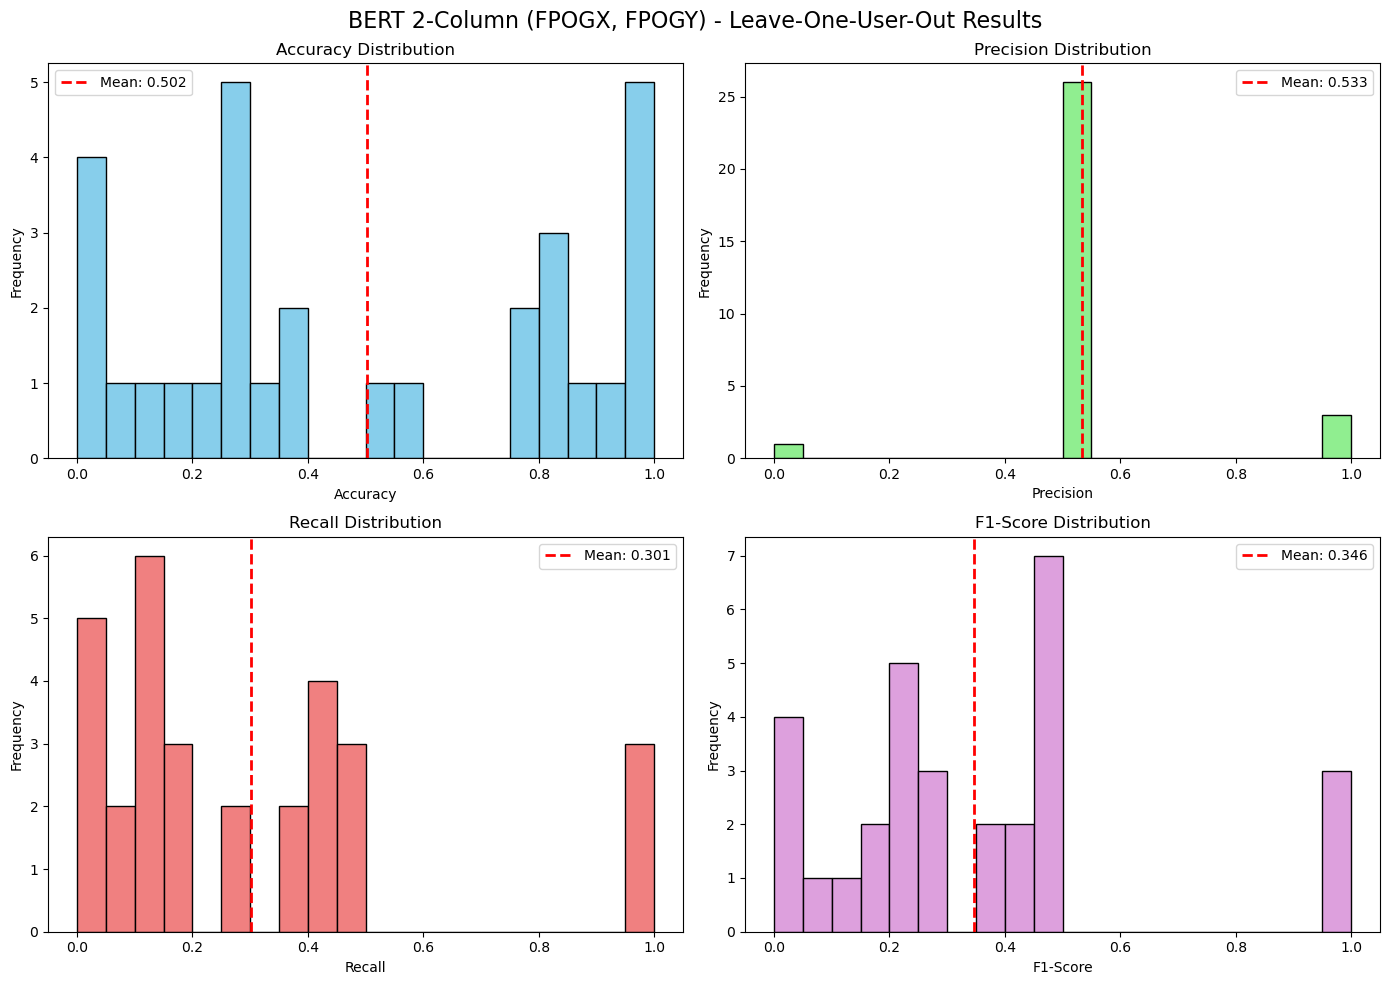

Visualization saved to: bert_2col_louo_distribution.png


In [8]:
# Plot performance distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('BERT 2-Column (FPOGX, FPOGY) - Leave-One-User-Out Results', fontsize=16)

# Accuracy
axes[0, 0].hist(results_df['accuracy'], bins=20, color='skyblue', edgecolor='black')
axes[0, 0].axvline(mean_accuracy, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_accuracy:.3f}')
axes[0, 0].set_xlabel('Accuracy')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Accuracy Distribution')
axes[0, 0].legend()

# Precision
axes[0, 1].hist(results_df['precision'], bins=20, color='lightgreen', edgecolor='black')
axes[0, 1].axvline(mean_precision, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_precision:.3f}')
axes[0, 1].set_xlabel('Precision')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Precision Distribution')
axes[0, 1].legend()

# Recall
axes[1, 0].hist(results_df['recall'], bins=20, color='lightcoral', edgecolor='black')
axes[1, 0].axvline(mean_recall, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_recall:.3f}')
axes[1, 0].set_xlabel('Recall')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Recall Distribution')
axes[1, 0].legend()

# F1-Score
axes[1, 1].hist(results_df['f1'], bins=20, color='plum', edgecolor='black')
axes[1, 1].axvline(mean_f1, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_f1:.3f}')
axes[1, 1].set_xlabel('F1-Score')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('F1-Score Distribution')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('bert_2col_louo_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization saved to: bert_2col_louo_distribution.png")

## Box Plot of Metrics

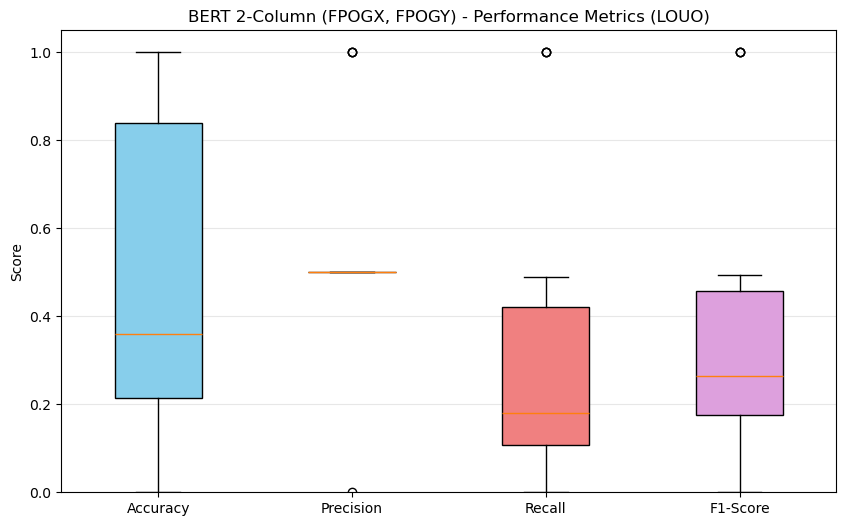

Box plot saved to: bert_2col_louo_boxplot.png


In [9]:
plt.figure(figsize=(10, 6))
metrics_data = results_df[['accuracy', 'precision', 'recall', 'f1']]

bp = plt.boxplot([metrics_data['accuracy'], metrics_data['precision'], 
                   metrics_data['recall'], metrics_data['f1']],
                  labels=['Accuracy', 'Precision', 'Recall', 'F1-Score'],
                  patch_artist=True)

colors = ['skyblue', 'lightgreen', 'lightcoral', 'plum']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

plt.ylabel('Score')
plt.title('BERT 2-Column (FPOGX, FPOGY) - Performance Metrics (LOUO)')
plt.grid(axis='y', alpha=0.3)
plt.ylim(0, 1.05)
plt.savefig('bert_2col_louo_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

print("Box plot saved to: bert_2col_louo_boxplot.png")

## Statistical Summary

In [10]:
print("\nDetailed Statistical Summary:")
print("="*60)
summary_stats = results_df[['accuracy', 'precision', 'recall', 'f1']].describe()
print(summary_stats)

print("\n" + "="*60)
print("Top 5 Users by Accuracy:")
print(results_df.nlargest(5, 'accuracy')[['user_id', 'accuracy', 'f1', 'n_samples']])

print("\nBottom 5 Users by Accuracy:")
print(results_df.nsmallest(5, 'accuracy')[['user_id', 'accuracy', 'f1', 'n_samples']])


Detailed Statistical Summary:
        accuracy  precision     recall         f1
count  30.000000  30.000000  30.000000  30.000000
mean    0.501973   0.533333   0.300986   0.345757
std     0.358134   0.182574   0.284782   0.270287
min     0.000000   0.000000   0.000000   0.000000
25%     0.215000   0.500000   0.107500   0.176587
50%     0.360000   0.500000   0.180000   0.264706
75%     0.840000   0.500000   0.420000   0.456522
max     1.000000   1.000000   1.000000   1.000000

Top 5 Users by Accuracy:
    user_id  accuracy        f1  n_samples
1         2  1.000000  1.000000         50
15       17  1.000000  1.000000         50
22       25  1.000000  1.000000         50
11       13  0.980000  0.494949         50
9        11  0.959184  0.489583         49

Bottom 5 Users by Accuracy:
    user_id  accuracy        f1  n_samples
7         9      0.00  0.000000         50
3         4      0.04  0.038462         50
5         7      0.04  0.038462         50
25       28      0.04  0.038462   